In [1]:
# Import required libraries
import torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import random
import torch.nn.functional as F

In [4]:
import math

In [5]:
# Got this data from "https://www.nseindia.com/reports-indices-historical-index-data".
# Need a better way to this. Ideally should work for any  user input ticker with any user input time frame.
df = pd.read_csv('/Users/shidhesh/Desktop/Projects/MLProjects/LLM_for_StockPrice_Prediction/MLP/data/NIFTY 50_Historical_PR_24092022to24092024.csv')
# convert the csv file into a dataframe.

In [111]:
# Add two new columns
df['Change'] = 0
df['Percent Change'] = 0

In [112]:
# populate both the columns with daily change and percent change.
df['Change'] = df['Close'] - df["Close"].shift(-1)
df['Percent Change'] = df['Change']/df['Close'].shift(-1)*100

In [114]:
# Tokenize. Put percent change in pre defined bins.
df['Token'] = 0
bins = [-10,-5,-2.5,-1,-0.25,0.25,1,2.5,5]
label = [0,1,2,3,4,5,6,7]
df['Token'] = pd.cut(df['Percent Change'], bins = bins, labels = label)

In [115]:
# Input data
data = list(df['Token'])[-2::-1]

In [117]:
# Convert the input data in sliding blocks of block_size(3) while the output will be the next token.
block_size = 3
X, Y = [], []
prev = data[:block_size]
for token in data[block_size:]:
    X.append(prev)
    Y.append(token)
    prev = prev[1:]+[token]
X = torch.tensor(X)
Y = torch.tensor(Y)
# X->Input tensor with each row of length block_size containing previous token
# Y->Output containing the token following the input tokens.


In [118]:
X.shape

torch.Size([491, 3])

In [119]:
# Each token is embedded in space of 2-d
emb_size = 2
h_layer_1 = 64

In [120]:
C = torch.randn((len(label),emb_size))

W1 = torch.randn((block_size*emb_size,h_layer_1))#*(5/3)/((block_size*emb_size)**0.5)
b1 = torch.randn(h_layer_1)*0.01

W2 = torch.randn((h_layer_1,len(label)))*0.01
b2 = torch.randn(len(label))*0

parameters = [C,W1,b1,W2,b2]

# MLP Input token -> Embedding Layer -> Hidden Layer(64 neurons) -> Output Layer -> Output Token

In [121]:
for p in parameters:
    p.requires_grad = True
# This makes sure that the parameters have gradient attribute that can be updated during backward pass.

In [122]:

batch_size = 16

In [123]:
steps = 100000
lr = 0.01 # Learning rate
for i in range(steps):
    ix = torch.randint(0,X.shape[0],(batch_size,)) # Randomly selects 16 (batch_size) inputs for each forward pass.
    # forward pass
    emb = C[X[ix]] # Embedding layer

    L1 = emb.view(emb.shape[0],-1)@W1+b1 # Hidden layer
    acc1 = torch.tanh(L1)

    logits = L1@W2+b2 # Output layer

    loss = F.cross_entropy(logits,Y[ix]) # loss calculation
    
    if i%10000 == 0:
        print(loss.item())

    # backward pass

    for p in parameters: # Makes all the gradients zero before each backward pass
        p.grad = None
    loss.backward() # Calculates new gradient

    # updates parameters
    for p in parameters:
        p.data += -lr*p.grad
print(loss.item()) # Final loss.

2.0533812046051025
1.2747609615325928
1.5027731657028198
1.1971769332885742
1.5904239416122437
1.322588324546814
1.3525997400283813
1.3362430334091187
1.1542400121688843
1.2851200103759766
1.0946475267410278


In [124]:
# Forward pass for all training data
emb = C[X]

L1 = emb.view(emb.shape[0],-1)@W1+b1
acc1 = torch.tanh(L1)

logits = L1@W2+b2

loss = F.cross_entropy(logits,Y)
loss.item()

1.3590549230575562

In [125]:
# This block of code traces the stock price movement based on prediction given by the above trained network.
pred = list(df['Close'][-block_size-1:])[::-1]
curr = X[0].tolist()
for _ in range(len(X)):
    # forward pass on current tokens
    emb = C[curr]

    L1 = emb.view(-1,W1.shape[0])@W1+b1
    acc1 = torch.tanh(L1)

    logits = L1@W2+b2
    
    
    prob = F.softmax(logits,dim =1) # probabilty distribution for next prediction.
    new = torch.multinomial(prob, num_samples = 1, replacement = True) # new token
    curr = curr[1:]+[new.item()] # next input
    
    # Calculates the next closing price of stock based on predicted token.
    next_pred = ((random.uniform(bins[new],bins[new+1]))/100 + 1)*pred[-1] 
    pred.append(next_pred)
print(pred[-1]) # Final stock price

23089.12210688416


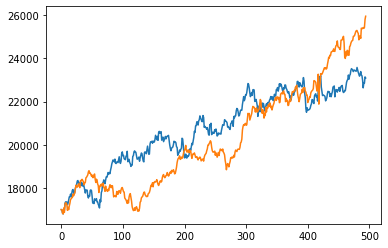

In [126]:
# Plots and compares the predicted price movement (blue) to the actual price movement(orange)
plt.plot(pred)
plt.plot(range(495),df['Close'][::-1])
plt.show()
# This is just one instance. Technically this should be repeated multiple times to gather general statistics.
# To be continued ...